# Benchmarks to try and improve the run time of minlp solver scaling up

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import itertools
import numpy as np
from collections import namedtuple
np.random.seed(42)

# For starters, we'll simply benchmark on fixed randomly generated test sets of increasing size, dimension and scale (decreased density).
sizes = [100]
dimensions = [2,3]
scales = [1]

Dataset = namedtuple("Dataset", "data size dimension scale source")

datasets = {(i,j,k): Dataset(np.random.rand(i,j) * k, i, j, k, "random") for i,j,k in itertools.product(sizes, dimensions, scales)}

Note: Below we're setting values for the min_volume and absolute errors that are based on the fact that we here know the underlying distribution to be uniform, which means that the true underlying $f(h)$ value for all patterns $h$ is actually $1$. We really only care about compuational effects, but the hope is that these are roughly the kinds of ranges that are relevant when dealing with actual anomaly detection problems and other distributions

In [6]:
from typing import Callable, List
import time
from rare_pattern_detect.minlp_based import MINLPModel

Parameter = namedtuple("Parameter", "name value")
# solver parameters
bound_included = [Parameter("bound included", v) for v in [0.05, 1]]
initial_patterns = [Parameter("initial pattern", v) for v in ["minimal", "maximal"]]
min_volumes = [Parameter("min volume", v) for v in [0.05, 0.1]]
absolute_errors = [Parameter("absolute error", v) for v in [1e-3, 0.1]] # thinking this through I believe whatever absolute error we set, we can simply add it to the epsilon of the pac performance.
relative_errors = [Parameter("relative error", v) for v in [1e-3, 0.1]] # this becomes useful especially if we set epsilon to be relative to an estimate of f.
# use_parallel_threads = [2, 4, 6]
# use_different_solvers = [Falase, ]

parameters = [bound_included,
              initial_patterns,
              min_volumes,
              absolute_errors,
              relative_errors
              ]

def generate_solver_settings(in_dict):
    solver_settings = {"tee": False}
    if "absolute error" in in_dict:
        solver_settings["absolute_bound_tolerance"] = in_dict["absolute error"]
    if "relative error" in in_dict:
        solver_settings["relative_bound_tolerance"] = in_dict["relative error"]
    return solver_settings

def run_on_testset(data, testdata, **kwargs):
    solutions = []
    optimal_count = 0
    for point in testdata:
        model = MINLPModel(data, min_volume="kwargs", **kwargs)
        status, result = model.find_min_f_hat(point, solver_settings=generate_solver_settings(kwargs))
        if status == "ok":
            solutions.append(result)
            optimal_count += 1
    return solutions, optimal_count, model.solver_settings

def run_on_whole_dataset(data):
    return run_on_testset(data, data)

def run_on_fixed_size_sample(data, size, **kwargs):
    np.random.seed(0)
    N = len(data)
    assert size <= N, "size larger than dataset"
    sample_indices = np.random.choice(N, max(1, size))
    return run_on_testset(data, data[sample_indices], **kwargs)

def run_on_fraction(data, fraction, **kwargs):
    return run_on_fixed_size_sample(data, round(len(data)*fraction), **kwargs)

def benchmark_and_store_result(expression: Callable):
    start = time.time()
    res = expression.__call__()
    end = time.time()
    return *res, end - start

In [7]:
import mlflow

def run_experiment(title, datasets, execution_function, sample_size, parameters: [[Parameter]]):
    """
    Wrapper function to run an experiment

    :param title: str
    :param datasets: dict[Any, Dataset]
    :param parameters: [[Parameter]]
    :param execution_function: A callable that expects as positional arguments an numpy array of shape (n_samples, n_features), a sample size: int and returns the estimated f_hats, a count of provably optimal values, and the and the model settings as dictionary.
    """
    mlflow.set_experiment(title)
    run_number = 0
    for parameter_combo in itertools.product(*parameters):
        for dataset in datasets.values():
            run_number += 1
            print(f"Running experiment number {run_number} for dataset {(dataset.size, dataset.dimension)} with parameters {[(p.name, p.value) for p in parameter_combo]}")
            with mlflow.start_run():

                # dataset parameters
                mlflow.log_param("size", dataset.size)
                mlflow.log_param("dimension", dataset.dimension)
                mlflow.log_param("density", dataset.scale)
                mlflow.log_param("source", dataset.source)

                # option parameters
                for parameter in parameter_combo:
                    mlflow.log_param(parameter.name, parameter.value)

                parameter_dict = {parameter.name : parameter.value for parameter in parameter_combo}

                # min_volume is expressed as fraction of scale
                if "min volume" in parameter_dict:
                    parameter_dict["min volume"] *= dataset.scale

                # timing results
                f_hats, optimal_count, solver_settings, time_passed = benchmark_and_store_result(lambda: execution_function(dataset.data,sample_size, **parameter_dict))
                performance = np.mean(f_hats)
                mlflow.log_metric("time", time_passed)
                mlflow.log_metric("optimal count", optimal_count)
                mlflow.log_metric("average f_hat", performance)
                print(f"Results: average f_hat: {performance}, time: {time_passed}")

                for k,v in solver_settings.items():
                    mlflow.log_param(k,v)

In [ ]:
run_experiment(title="MINLP Tweaking Small after debugging",
               execution_function=run_on_fixed_size_sample,
               sample_size=10,
               datasets=datasets,
               parameters=parameters)

# Results for the isolation forest

Here, instead of running the exact solver, we use the sampling procedure from the isolation forest, but we use family of scoring functions that are based on the sampled distribution of f_hat.

In [5]:
from rare_pattern_detect.if_based import IFBasedRarePatternDetect

In [9]:
data = datasets[100,2,1].data

if_pac_estimator = IFBasedRarePatternDetect(
    n_estimators = 100
)
if_pac_estimator.fit(data)

In [92]:
def run_if_pac_on_dataset(data, sample_size, **kwargs):
    if_pac_estimator = IFBasedRarePatternDetect(random_state= 42, n_estimators=kwargs["n_estimators"])
    if_pac_estimator.fit(data)
    np.random.seed(0)
    N = len(data)
    assert sample_size <= N, "size larger than dataset"
    sample_indices = np.random.choice(N, max(1, sample_size))
    f_hats = if_pac_estimator.score_samples(
        data[sample_indices],
        alpha=kwargs["alpha"]
    )
    # using this method we don't generally know whether the result is optimal.
    optimal_count = 0
    return f_hats, optimal_count, {} # since the kwargs are already logged, we don't need to do it again.

parameters_if = [
    [Parameter("n_estimators", v) for v in [100, 1000, 10000]],
    [Parameter("alpha", v) for v in [0,0.5, 1,2,np.inf]]
]

In [93]:
run_experiment('IF based PACRPAD',
               execution_function=run_if_pac_on_dataset,
               sample_size=10,
               parameters=parameters_if,
               datasets=datasets)

Running experiment number 1 for dataset (100, 2) with parameters [('n_estimators', 100), ('alpha', 0)]
Results: average f_hat: 62.38405984552797, time: 0.06628608703613281
Running experiment number 2 for dataset (100, 3) with parameters [('n_estimators', 100), ('alpha', 0)]
Results: average f_hat: 17.59795638677466, time: 0.06410694122314453
Running experiment number 3 for dataset (100, 2) with parameters [('n_estimators', 100), ('alpha', 0.5)]
Results: average f_hat: 19.773585757823422, time: 0.06266975402832031
Running experiment number 4 for dataset (100, 3) with parameters [('n_estimators', 100), ('alpha', 0.5)]
Results: average f_hat: 14.727073687946348, time: 0.06962728500366211
Running experiment number 5 for dataset (100, 2) with parameters [('n_estimators', 100), ('alpha', 1)]
Results: average f_hat: 14.85614620900437, time: 0.06471920013427734
Running experiment number 6 for dataset (100, 3) with parameters [('n_estimators', 100), ('alpha', 1)]
Results: average f_hat: 12.7169

In [11]:
minlp_runs = mlflow.search_runs("271883002980108978")
minlp_runs['model'] = "minlp"
if_pac_runs = mlflow.search_runs("755152897400520712")
if_pac_runs['model'] = 'if_pac'

In [19]:
import pandas as pd
all_runs = pd.concat([minlp_runs, if_pac_runs])
all_runs["params.n_estimators"] = all_runs["params.n_estimators"].fillna(1)

<AxesSubplot: xlabel='metrics.average f_hat', ylabel='params.dimension'>

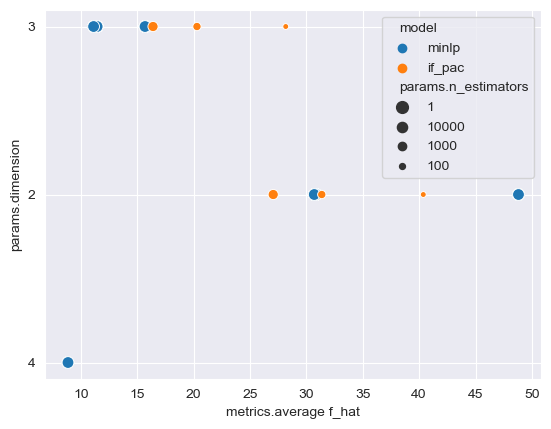

In [20]:

import seaborn as sns

df = all_runs[(all_runs['params.dimension'] <= '3') & (all_runs['status'] == 'FINISHED')].groupby(['model', 'params.dimension', 'params.n_estimators'], dropna=False)['metrics.average f_hat'].min()


sns.scatterplot(all_runs, x='metrics.average f_hat', y='params.dimension', hue="model", size="params.n_estimators")


This is weird insofar as as the if_model should never outperform the exact model.


## Performance comparison on actual anomaly datasets

In this section, we look at the performance of the various Renyi entropies on actual anomaly datasets.

In [3]:
# Loading the data
with np.load('../../ADBench/datasets/Classical/34_smtp.npz') as data:
    X = data['X']
    y = data['y']

anomalies_indices = [i for i, j in enumerate(y) if j == 1]
normal_indices = [i for i, j in enumerate(y) if j != 1]

print("anomalies_indices: ", len(anomalies_indices))
print("normal_indices: ", len(normal_indices))

TRAINING_SIZE = 100
TESTING_SIZE = 20
TRAINING_ANOMALIES_INDICES = 10

np.random.seed(0)
sample_indices = np.random.choice(len(X), TESTING_SIZE)
#
# testing_anomalies_indices = anomalies_indices[-TESTING_SIZE:]
#
# testing_normal_indices = normal_indices[-TESTING_SIZE:]
#
# training_normal_indices = normal_indices[:TRAINING_SIZE]
#
# training_anomalies_indices = anomalies_indices[:TRAINING_ANOMALIES_INDICES]
#
# testing_indices = np.concatenate((testing_anomalies_indices, testing_normal_indices))
#
# testing_labels = y[testing_indices]
#
# y = testing_labels
#
# training_set = np.array(np.concatenate((X[training_normal_indices],X[training_anomalies_indices])))
#
# testing_set = np.array(np.concatenate((X[testing_anomalies_indices],X[testing_normal_indices])))

anomalies_indices:  30
normal_indices:  95126


NotFittedError: This IFBasedRarePatternDetect instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

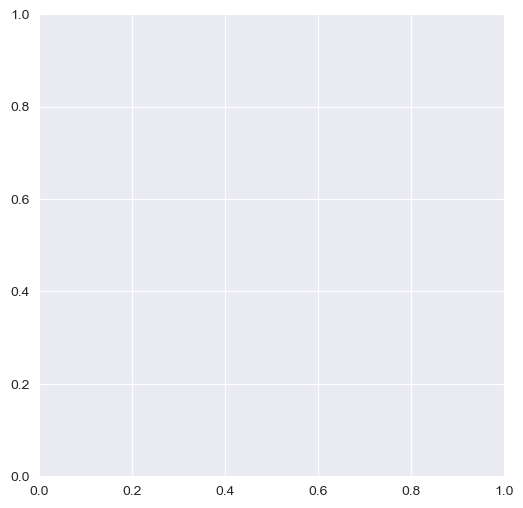

In [6]:
from itertools import cycle
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))
colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for n, color in zip(cycle([100]), colors):

    if_pac_estimator = IFBasedRarePatternDetect(random_state=42, n_estimators=n)
    if_pac_estimator.fit(X)
    if_scores = if_pac_estimator.get_if_scores(X)

    RocCurveDisplay.from_predictions(y, if_scores, pos_label=0, color="orange", ax=ax, name="IF")

    for alpha in [0,0.5,1,2, np.inf]:

        if_pac_scores = if_pac_estimator.pac_score_samples(X, alpha)
        RocCurveDisplay.from_predictions(y, if_pac_scores, pos_label=0, color=color, ax=ax, name=f"IF_PAC-{alpha}")

In [98]:
if_pac_estimator = IFBasedRarePatternDetect(random_state=42, n_estimators=100)
if_pac_estimator.fit(X)

In [ ]:
if_pac_scores = if_pac_estimator.score_samples(X, 0)

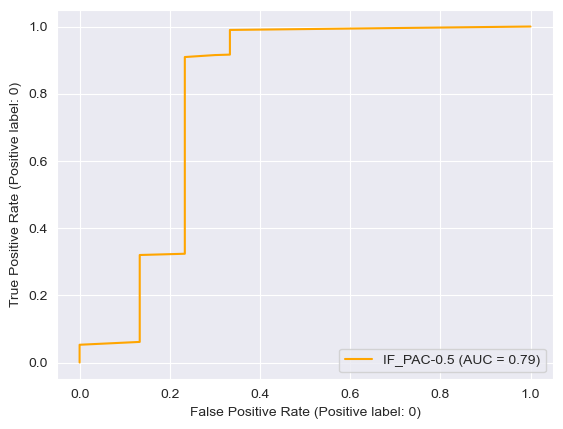

In [105]:
RocCurveDisplay.from_predictions(y, if_pac_scores, pos_label=0, color="orange", name=f"IF_PAC-{0.5}")

In [103]:
%matplotlib inline